#Download & Extract Data

In [1]:
!kaggle datasets download -d splcher/animefacedataset
!unzip /content/animefacedataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [2]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set
!unzip /content/cartoon-faces-googles-cartoon-set.zip

Streaming output truncated to the last 5000 lines.
  inflating: cartoonset100k_jpg/9/cs9241369635511208616.jpg  
  inflating: cartoonset100k_jpg/9/cs9241944887490894642.jpg  
  inflating: cartoonset100k_jpg/9/cs9242341144381494552.jpg  
  inflating: cartoonset100k_jpg/9/cs9242721282876118063.jpg  
  inflating: cartoonset100k_jpg/9/cs9242724767079327023.jpg  
  inflating: cartoonset100k_jpg/9/cs9242747830253082200.jpg  
  inflating: cartoonset100k_jpg/9/cs9242822867113421129.jpg  
  inflating: cartoonset100k_jpg/9/cs9242996991614141095.jpg  
  inflating: cartoonset100k_jpg/9/cs9243303694280080212.jpg  
  inflating: cartoonset100k_jpg/9/cs9243342474858925237.jpg  
  inflating: cartoonset100k_jpg/9/cs9243791274208387689.jpg  
  inflating: cartoonset100k_jpg/9/cs9243899119400400875.jpg  
  inflating: cartoonset100k_jpg/9/cs9243957903362916314.jpg  
  inflating: cartoonset100k_jpg/9/cs9243992095529548774.jpg  
  inflating: cartoonset100k_jpg/9/cs924416123669405215.jpg  
  inflating: cartoon

#Import libraries

In [3]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
from torchsummary import summary
import torch.nn.functional as F

#Data Preprocessing

In [4]:
# Check for GPUs and set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Define paths
anime_faces_folder = '/content/images'

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load half of anime faces
anime_files = os.listdir(anime_faces_folder)
random.shuffle(anime_files)
anime_files = anime_files[:len(anime_files)//2]
anime_images = [os.path.join(anime_faces_folder, f) for f in anime_files]
anime_labels = [0] * len(anime_images)

# Create dataset and dataloader
dataset = ImageDataset(image_paths=anime_images, labels=anime_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)


In [7]:
# Randomly sample 5 images
random_images = random.sample(range(len(dataset)), 5)
random_images

[17423, 11376, 24994, 1873, 29238]

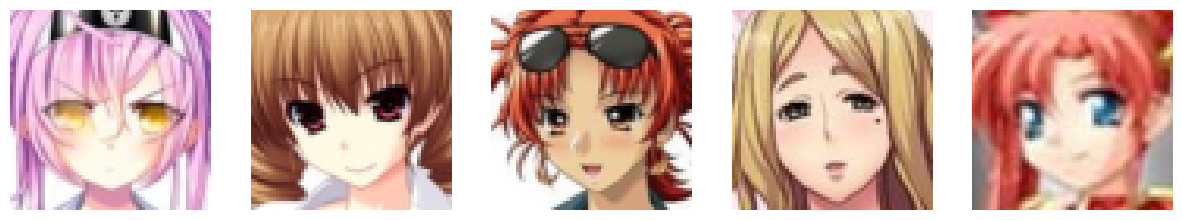

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [8]:
# Randomly sample 5 images
random_images = random.sample(range(len(dataset)), 5)

# Display the images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_images):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(dataset[idx][0].numpy(), (1,2,0)))
    plt.axis("off")
    filename = f'random_image_{i+1}.png'  # Dynamically create filename
    plt.imsave(filename, np.transpose(dataset[idx][0].numpy(), (1,2,0)), cmap='gray')  # Save image using plt.imsave
plt.show()
plt

In [9]:
# Custom sampling function
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = torch.randn_like(log_var)  # Sample from a normal distribution
    return mean + torch.exp(log_var / 2) * epsilon

In [10]:
# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.block1 = ResNetBlock(3, 32, stride=2)
        self.block2 = ResNetBlock(32, 64, stride=2)
        self.fc_mean = nn.Linear(64 * 16 * 16, latent_dim)
        self.fc_log_var = nn.Linear(64 * 16 * 16, latent_dim)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean,log_var

In [12]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, mean, log_var):
        epsilon = torch.randn_like(mean)  # Sample from a normal distribution
        return mean + torch.exp(log_var / 2) * epsilon

class Encoder2(nn.Module):
    def __init__(self, input_shape1, input_shape2):
        super(Encoder2, self).__init__()
        self.sampling = Sampling()

    def forward(self, mean, log_var):
        return self.sampling(mean, log_var)


In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 16 * 16)
        self.block1 = ResNetBlock(64, 32, stride=1)
        self.block2 = ResNetBlock(32, 3, stride=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 64, 16, 16)
        x = self.up1(x)
        x = self.block1(x)
        x = self.up2(x)
        x = self.block2(x)
        x_reconstructed = torch.sigmoid(x)
        x_reconstructed = x_reconstructed.view(-1, 3, 64, 64)
        return x_reconstructed

In [14]:
# Define reconstruction loss (MSE)
def mse_loss(y_true, y_pred):
    return  F.binary_cross_entropy(recon_x, x, reduction='mean')

# Define KL divergence loss
def kl_loss(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)

# Define VAE loss
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return r_loss + kl_loss_.mean(), r_loss.mean(), kl_loss_.mean()


In [15]:
latent_dim = 128

In [16]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)

        self.sampling = Encoder2(latent_dim,latent_dim)

        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.sampling(mean, log_var)
        recon_x = self.decoder(z)

        kl_loss = -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())

        return kl_loss, recon_x

In [23]:
import numpy as np

def generate_image(model):
    model.eval()
    with torch.no_grad():
        # Sample from the latent space (assuming standard normal distribution for simplicity)
        z = torch.randn(8, latent_dim).to(device)

        generated_images = model.decoder(z)
        generated_images = generated_images.squeeze(0).cpu().detach().numpy()  # Convert tensor to numpy array

    # Rescale pixel values to range [0, 1]
    generated_images = np.clip(generated_images, 0, 1)

    # Plot the generated image
    plt.figure(figsize=(6*8, 6))
    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.imshow(np.transpose(generated_images[i], (1,2,0)))
        plt.axis("off")
        # Save each subplot as an individual image
        filename = os.path.join('/content/created_images/', f'generated_image_{i+1}.png')
        plt.imsave(filename, np.transpose(generated_images[i], (1, 2, 0)))
    plt.show()

6407139
Epoch [1/5], Batch [1/497], Loss: 1.0120
Epoch [1/5], Batch [101/497], Loss: 2.5293
Epoch [1/5], Batch [201/497], Loss: 1.1801
Epoch [1/5], Batch [301/497], Loss: 0.7605
Epoch [1/5], Batch [401/497], Loss: 0.6795


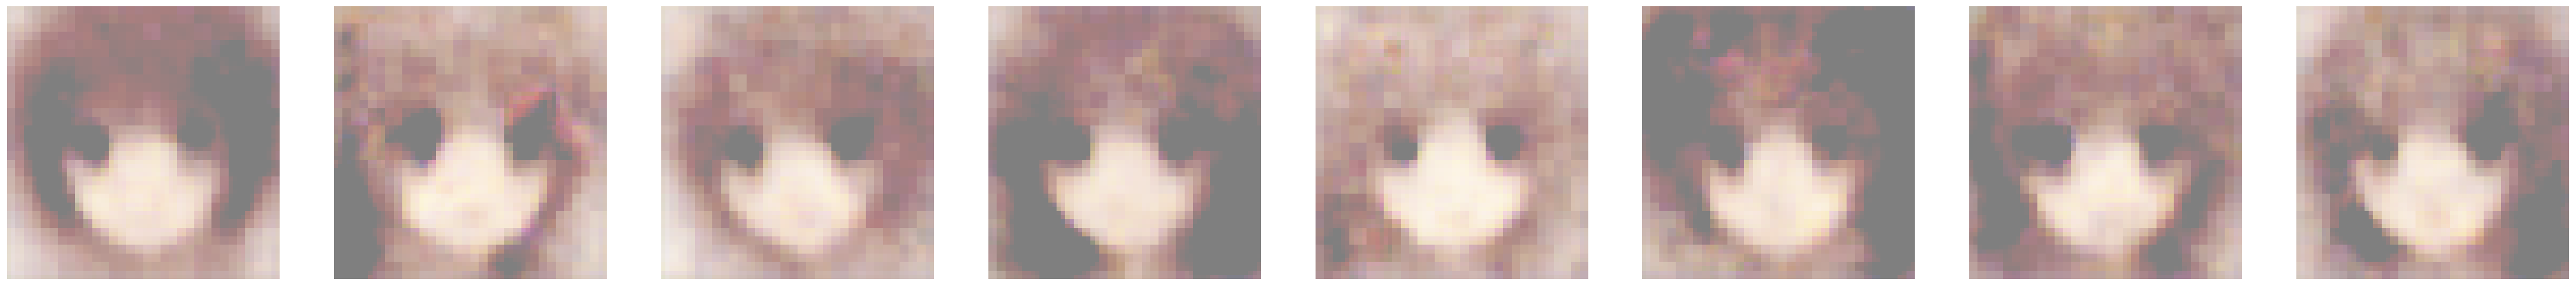

Epoch [1/5], Total Loss: 2.7366
Epoch [1/5], Total Recon Loss: 0.6134
Epoch [2/5], Batch [1/497], Loss: 0.6527
Epoch [2/5], Batch [101/497], Loss: 0.6584
Epoch [2/5], Batch [201/497], Loss: 0.6439
Epoch [2/5], Batch [301/497], Loss: 0.6318
Epoch [2/5], Batch [401/497], Loss: 0.6465


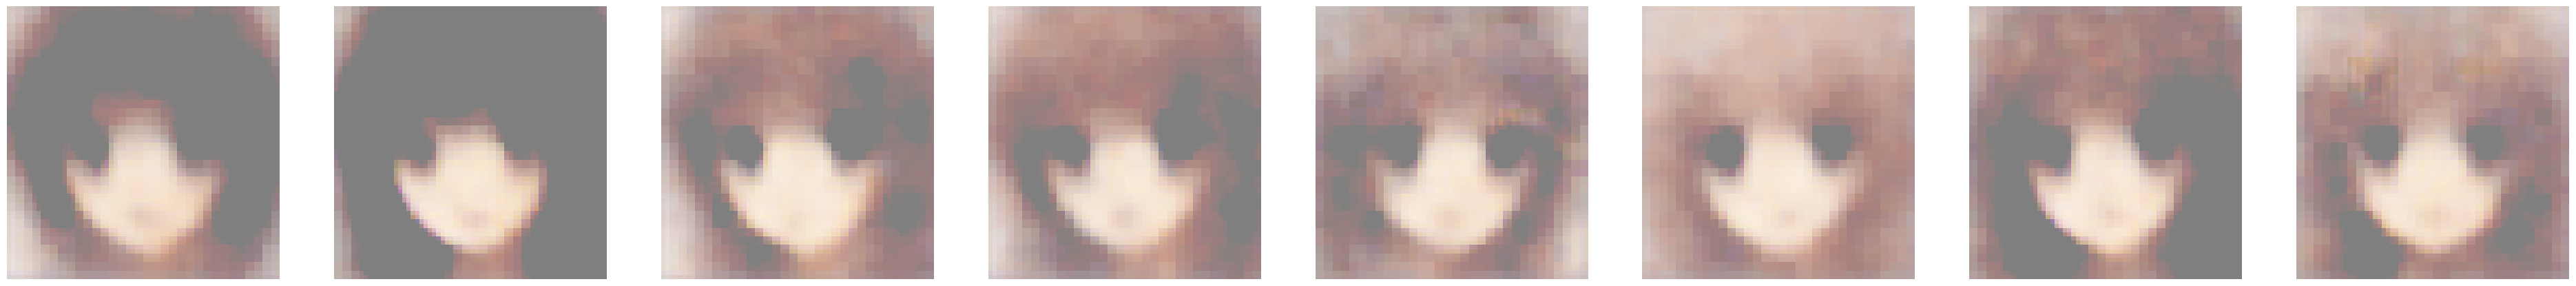

Epoch [2/5], Total Loss: 0.6430
Epoch [2/5], Total Recon Loss: 0.6042
Epoch [3/5], Batch [1/497], Loss: 0.6297
Epoch [3/5], Batch [101/497], Loss: 0.6274
Epoch [3/5], Batch [201/497], Loss: 0.6435
Epoch [3/5], Batch [301/497], Loss: 0.6336
Epoch [3/5], Batch [401/497], Loss: 0.6270


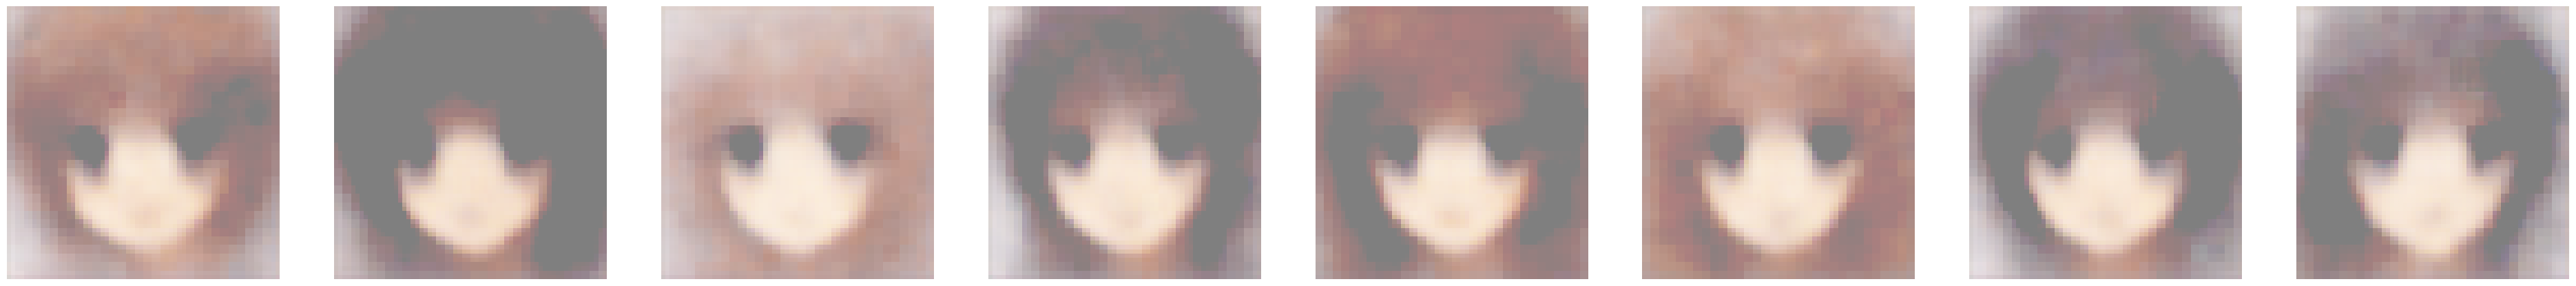

Epoch [3/5], Total Loss: 0.6312
Epoch [3/5], Total Recon Loss: 0.6032
Epoch [4/5], Batch [1/497], Loss: 0.6266
Epoch [4/5], Batch [101/497], Loss: 0.6245
Epoch [4/5], Batch [201/497], Loss: 0.6291
Epoch [4/5], Batch [301/497], Loss: 0.6268
Epoch [4/5], Batch [401/497], Loss: 0.6152


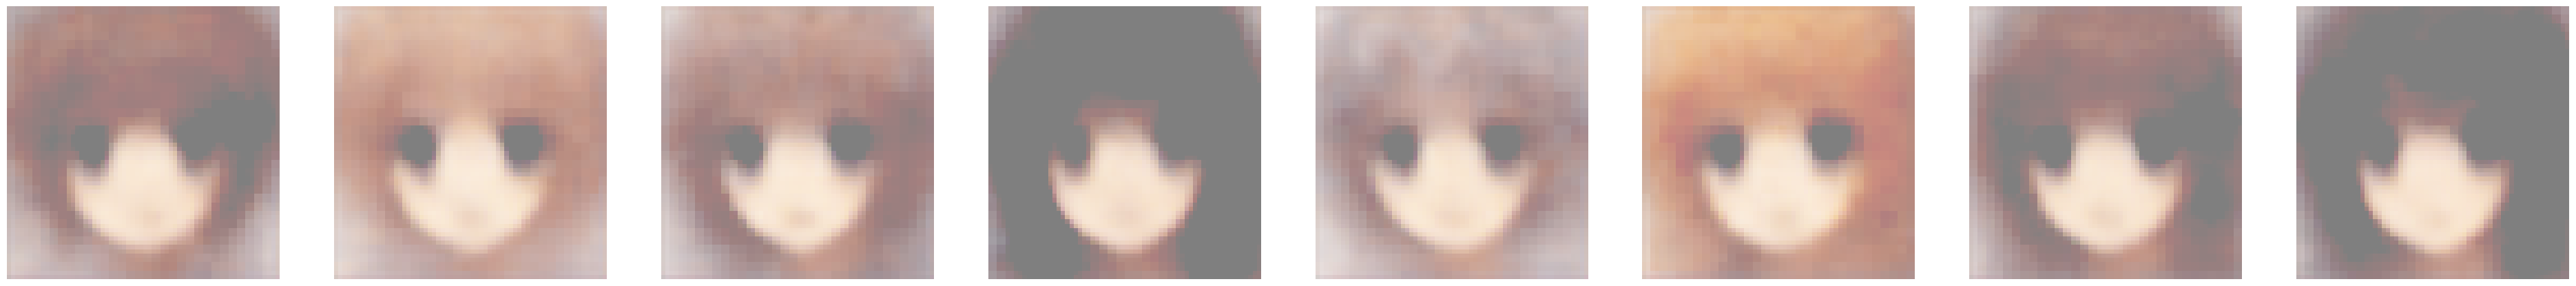

Epoch [4/5], Total Loss: 0.6252
Epoch [4/5], Total Recon Loss: 0.6029
Epoch [5/5], Batch [1/497], Loss: 0.6164
Epoch [5/5], Batch [101/497], Loss: 0.6234
Epoch [5/5], Batch [201/497], Loss: 0.6368
Epoch [5/5], Batch [301/497], Loss: 0.6162
Epoch [5/5], Batch [401/497], Loss: 0.6250


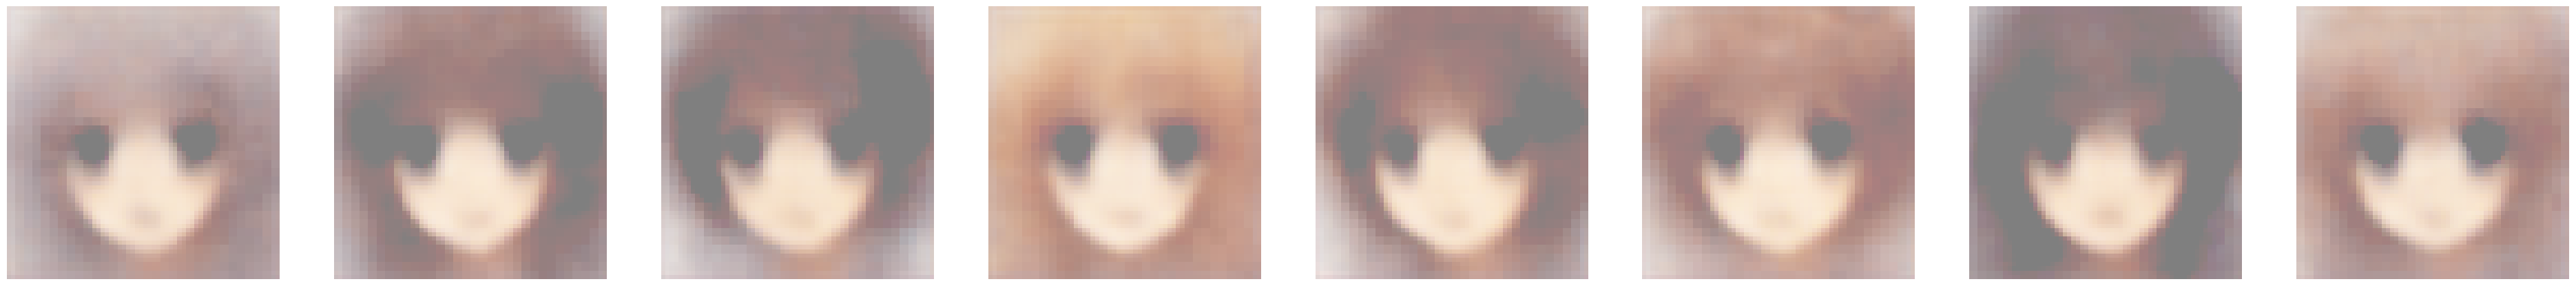

Epoch [5/5], Total Loss: 0.6221
Epoch [5/5], Total Recon Loss: 0.6027


In [24]:
loss_ = []
r_l = []
kl_l = []
# Initialize VQVAE model
model = VAE(latent_dim).to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_recon_loss = 0
    total_loss=0
    total_kl_l = 0
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()
        kl_loss, recon_x = model(x)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
        loss = recon_loss + kl_loss


        loss.backward()
        optimizer.step()

        total_recon_loss += recon_loss.item()
        total_loss += loss.item()
        total_kl_l += kl_loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    generate_image(model)
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss / len(dataloader):.4f}")
    loss_.append(total_loss / len(dataloader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Recon Loss: {total_recon_loss / len(dataloader):.4f}")
    r_l.append(total_recon_loss / len(dataloader))

# Save trained model
torch.save(model.state_dict(), 'vqvae_model.pth')


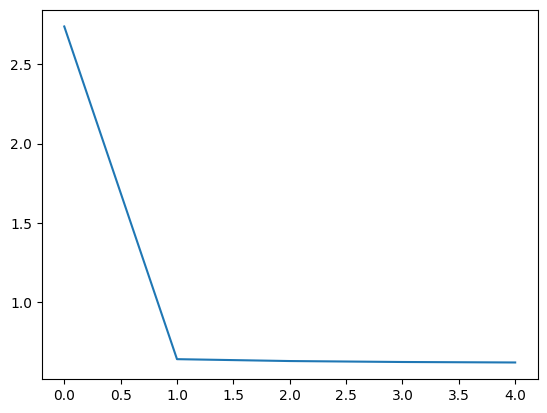

In [25]:
plt.plot([np.mean(l) for l in loss_])

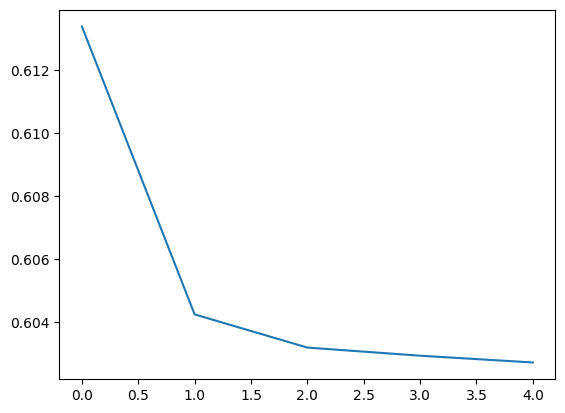

In [26]:
plt.plot([np.mean(l) for l in r_l])